In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
import os
import shutil
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')





Mounted at /content/drive


In [ ]:
# Step 2: Unzip the file
zip_path = '/content/drive/MyDrive/BleedingGI.zip'  # Update the path if needed
unzip_path = '/content/drive/MyDrive/'
!unzip -q "$zip_path" -d "$unzip_path"

In [ ]:
# Step 3: Set up directories for training, validation, and test sets
output_dir = '/content/drive/MyDrive/BleedingGI_Split'
os.makedirs(output_dir, exist_ok=True)


In [ ]:

# Create subdirectories
dirs = ['train/normal', 'val/normal', 'val/lesion', 'test/normal', 'test/lesion']
for d in dirs:
    os.makedirs(os.path.join(output_dir, d), exist_ok=True)

unzip_path = '/content/drive/MyDrive/GastrointestinalBleeding/'

# Step 4: List all images
normal_images = os.listdir(os.path.join(unzip_path, 'Normal'))
lesion_images = os.listdir(os.path.join(unzip_path, 'Lesion'))

# Step 5: Split data
# 80% training (only normal), 10% validation (balanced), 10% test (balanced)
train_normal, temp_normal = train_test_split(normal_images, test_size=0.2, random_state=42)
val_normal, test_normal = train_test_split(temp_normal, test_size=0.5, random_state=42)
val_lesion, test_lesion = train_test_split(lesion_images, test_size=0.5, random_state=42)

# Step 6: Copy images to corresponding directories
def copy_images(file_list, source_dir, target_dir):
    for file_name in file_list:
        src = os.path.join(source_dir, file_name)
        dest = os.path.join(target_dir, file_name)
        shutil.copy(src, dest)

# Copy normal images
copy_images(train_normal, os.path.join(unzip_path, 'Normal'), os.path.join(output_dir, 'train/normal'))
copy_images(val_normal, os.path.join(unzip_path, 'Normal'), os.path.join(output_dir, 'val/normal'))
copy_images(test_normal, os.path.join(unzip_path, 'Normal'), os.path.join(output_dir, 'test/normal'))

# Copy lesion images
copy_images(val_lesion, os.path.join(unzip_path, 'Lesion'), os.path.join(output_dir, 'val/lesion'))
copy_images(test_lesion, os.path.join(unzip_path, 'Lesion'), os.path.join(output_dir, 'test/lesion'))

print("Data splitting complete. The dataset is organized as follows:")
!tree "$output_dir"


Data splitting complete. The dataset is organized as follows:
/bin/bash: line 1: tree: command not found


In [ ]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Set target image size
IMAGE_SIZE = (128, 128)  # Resize to 128x128 pixels

# Paths
base_dir = '/content/drive/MyDrive/BleedingGI_Split'
train_normal_dir = os.path.join(base_dir, 'train/normal')

# Step 1: Load and resize BMP images
def load_images_from_directory(directory, target_size):
    """
    Load BMP images from a directory and resize them to a uniform size.
    Args:
        directory (str): Path to the image directory.
        target_size (tuple): Target size for resizing (width, height).
    Returns:
        np.ndarray: Array of resized and normalized images.
    """
    images = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.bmp'):  # Check for BMP files
            file_path = os.path.join(directory, file_name)
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if image is not None:
                # Resize the image to target size
                resized_image = cv2.resize(image, target_size)
                # Normalize pixel values to [0, 1]
                images.append(resized_image / 255.0)
    return np.array(images)

# Debug: Check directory contents
print(f"Checking directory: {train_normal_dir}")
print("Files in directory:", os.listdir(train_normal_dir))

# Load BMP images
normal_images = load_images_from_directory(train_normal_dir, IMAGE_SIZE)
print(f"Number of normal training images loaded: {len(normal_images)}")

# Ensure normal_images is not empty
if len(normal_images) == 0:
    raise ValueError("No BMP images found in the specified directory. Check the file paths and formats.")

# Step 2: Split dataset into training and validation sets
train_data, val_data = train_test_split(normal_images, test_size=0.1, random_state=42)

print(f"Dataset split successful. Training data size: {len(train_data)}, Validation data size: {len(val_data)}")


Checking directory: /content/drive/MyDrive/BleedingGI_Split/train/normal
Files in directory: ['72140001224_20220701_00018.bmp', '72190042453_20220627_00008.bmp', '72210127243_20211105_00031.bmp', '72210127243_20211105_00003.bmp', '72140001224_20220701_00005.bmp', '72140001224_20220701_00033.bmp', '72210127243_20211105_00029.bmp', '72200048474_20210824_00010.bmp', '72140001224_20211123_00016.bmp', '72140001224_20220701_00017.bmp', '72210125426_20211012_00017.bmp', '72140001224_20211123_00010.bmp', '72140001224_20220701_00020.bmp', '72170102441_20220714_00014.bmp', '72170169177_20220706_00003.bmp', '72140001224_20220701_00015.bmp', '72140001224_20220701_00029.bmp', '72140001224_20211123_00006.bmp', '72170102441_20220714_00003.bmp', '72170169177_20220706_00002.bmp', '72140001224_20220701_00026.bmp', '72140001224_20220701_00022.bmp', '72140001224_20211123_00017.bmp', '72210125426_20211012_00014.bmp', '72140001224_20220701_00021.bmp', '72170102441_20220714_00004.bmp', '72140001224_20211123_

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Define Combined Loss Function (MSE + SSIM)
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim = 1 - tf.image.ssim(y_true, y_pred, max_val=1.0)
    return mse + ssim

# Define Self-Attention Block
def self_attention_block(inputs):
    attention = layers.Conv2D(128, (1, 1), activation='relu', padding='same')(inputs)
    attention = layers.Softmax(axis=-1)(attention)  # Compute attention weights
    return layers.Multiply()([inputs, attention])  # Multiply input by attention weights

# Build the improved autoencoder with attention mechanisms
def build_attention_autoencoder(input_shape):
    # Encoder
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Add self-attention block
    x = self_attention_block(x)

    # Additional Downsampling Layer
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # Reduced latent space

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(inputs, decoded)

# Compile the autoencoder with combined loss
attention_autoencoder = build_attention_autoencoder((128, 128, 3))
attention_autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss)
attention_autoencoder.summary()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3
)

# Augment training data
train_data_augmented = datagen.flow(train_data, train_data, batch_size=32)

# Train the improved autoencoder with attention mechanisms
history = attention_autoencoder.fit(
    train_data_augmented,
    validation_data=(val_data, val_data),
    epochs=200,
    steps_per_epoch=len(train_data) // 32,  # Batches per epoch
    shuffle=True
)

# Save the improved model with attention mechanisms
attention_autoencoder.save('/content/improved_autoencoder_with_attention.h5')
print("Improved model with attention mechanisms training complete and saved.")


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 128, 128, 32)   │            896 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 128, 128, 32)   │            128 │ conv2d_74[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 64, 64, 32)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 64, 64, 64)     │            256 │ conv2d_75[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 32, 32, 128)    │            512 │ conv2d_76[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 16, 16, 128)    │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 16, 16, 128)    │         16,512 │ max_pooling2d_34[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax_1 (Softmax)       │ (None, 16, 16, 128)    │              0 │ conv2d_77[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 16, 16, 128)    │              0 │ max_pooling2d_34[0][0… │
│                           │                        │                │ softmax_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_35          │ (None, 8, 8, 128)      │              0 │ multiply_1[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 8, 8, 128)      │        147,584 │ max_pooling2d_35[0][0] │
├──────────────────────

 Total params: 500,355 (1.91 MB)

 Trainable params: 499,203 (1.90 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 1.0090 - val_loss: 0.6156
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9854 - val_loss: 0.6158
Epoch 3/200


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9628 - val_loss: 0.6161
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.9380 - val_loss: 0.6162
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9338 - val_loss: 0.6166
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9084 - val_loss: 0.6168
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.8921 - val_loss: 0.6173
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8572 - val_loss: 0.6175
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.8568 - val_loss: 0.6178
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8459 - val_loss: 0.6181
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.8219 - val_loss: 0.6186
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7868 - val_loss: 0.6188
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.7969 - val_loss: 0.6193
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7916 - val_loss: 0.6196

Improved model with attention mechanisms training complete and saved.


In [ ]:
def calculate_reconstruction_error(image_path, model, image_size=(128, 128)):
    """
    Load an image, preprocess it, and calculate the reconstruction error.
    Args:
        image_path (str): Path to the image file.
        model (tf.keras.Model): Trained autoencoder model.
        image_size (tuple): Target size for resizing the image.
    Returns:
        float: Reconstruction error (MSE).
    """
    # Load and preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, image_size) / 255.0  # Resize and normalize
    reconstructed_image = model.predict(image[np.newaxis, ...])

    # Calculate reconstruction error (MSE)
    mse = np.mean((image - reconstructed_image[0]) ** 2)
    return mse


In [ ]:
# Example directory paths (update paths as per your dataset structure)
val_normal_dir = '/content/drive/MyDrive/BleedingGI_Split/val/normal'
val_lesion_dir = '/content/drive/MyDrive/BleedingGI_Split/val/lesion'

# Get list of file paths
val_normal_paths = [os.path.join(val_normal_dir, f) for f in os.listdir(val_normal_dir) if f.endswith('.bmp')]
val_lesion_paths = [os.path.join(val_lesion_dir, f) for f in os.listdir(val_lesion_dir) if f.endswith('.bmp')]

# Calculate reconstruction errors
val_normal_errors = [calculate_reconstruction_error(path, autoencoder) for path in val_normal_paths]
val_lesion_errors = [calculate_reconstruction_error(path, autoencoder) for path in val_lesion_paths]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

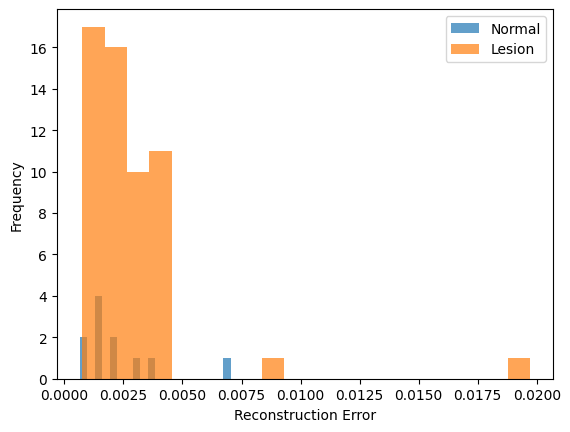

In [ ]:
import matplotlib.pyplot as plt

plt.hist(val_normal_errors, bins=20, alpha=0.7, label='Normal')
plt.hist(val_lesion_errors, bins=20, alpha=0.7, label='Lesion')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
threshold = np.mean(val_normal_errors) + 2 * np.std(val_normal_errors)
print(f"Anomaly detection threshold: {threshold}")


Anomaly detection threshold: 0.005743204366817117


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate reconstruction errors for test datasets
test_normal_errors = [calculate_reconstruction_error(path, improved_autoencoder) for path in test_normal_paths]
test_lesion_errors = [calculate_reconstruction_error(path, improved_autoencoder) for path in test_lesion_paths]

# Create ground truth labels
y_true = [0] * len(test_normal_errors) + [1] * len(test_lesion_errors)  # 0 = normal, 1 = lesion

# Combine errors and define a threshold
y_scores = test_normal_errors + test_lesion_errors
threshold = 0.005  # Adjust this based on your ROC curve or experimentation

# Generate predictions based on the threshold
y_pred = [0 if error <= threshold else 1 for error in y_scores]

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


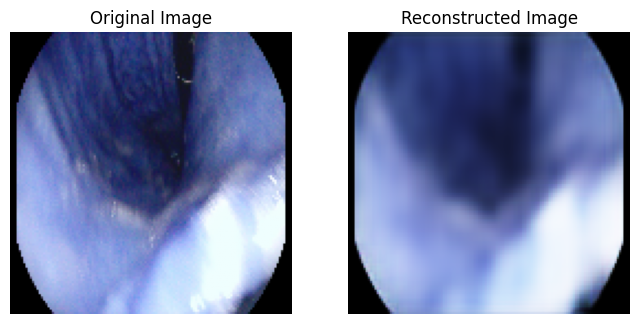

In [ ]:
import matplotlib.pyplot as plt

# Choose a test image
test_image_path = test_lesion_paths[2]  # Replace with a real lesion image path
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (128, 128)) / 255.0

# Reconstruct the image
reconstructed_image = autoencoder.predict(test_image[np.newaxis, ...])[0]

# Plot original and reconstructed images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(test_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis('off')

plt.show()


In [ ]:
error = calculate_reconstruction_error(test_image_path, autoencoder)
print(f"Reconstruction error: {error}")
print(f"Threshold: {threshold}")
if error <= threshold:
    print("Image is classified as normal.")
else:
    print("Image is classified as an anomaly.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Reconstruction error: 0.0014163435943027587
Threshold: 0.005
Image is classified as normal.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

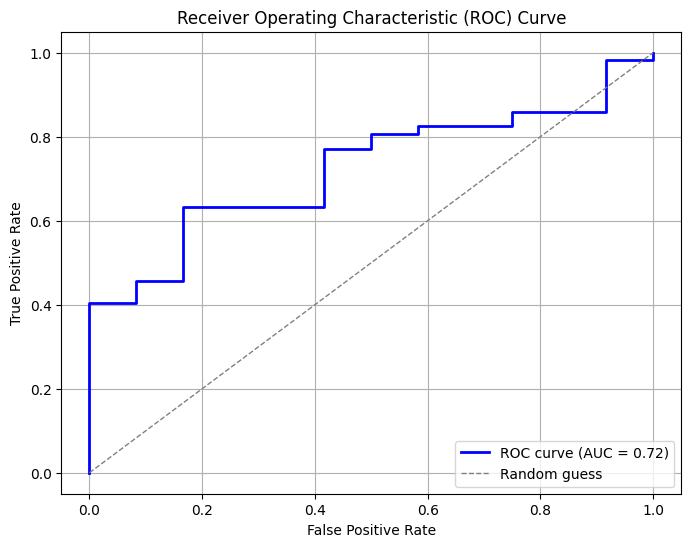

AUC-ROC: 0.72


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate reconstruction errors for test datasets
test_normal_errors = [calculate_reconstruction_error(path, improved_autoencoder) for path in test_normal_paths]
test_lesion_errors = [calculate_reconstruction_error(path, improved_autoencoder) for path in test_lesion_paths]

# Create ground truth labels and scores
y_true = [0] * len(test_normal_errors) + [1] * len(test_lesion_errors)  # 0 = normal, 1 = lesion
y_scores = test_normal_errors + test_lesion_errors  # Reconstruction errors as scores

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC
print(f"AUC-ROC: {roc_auc:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


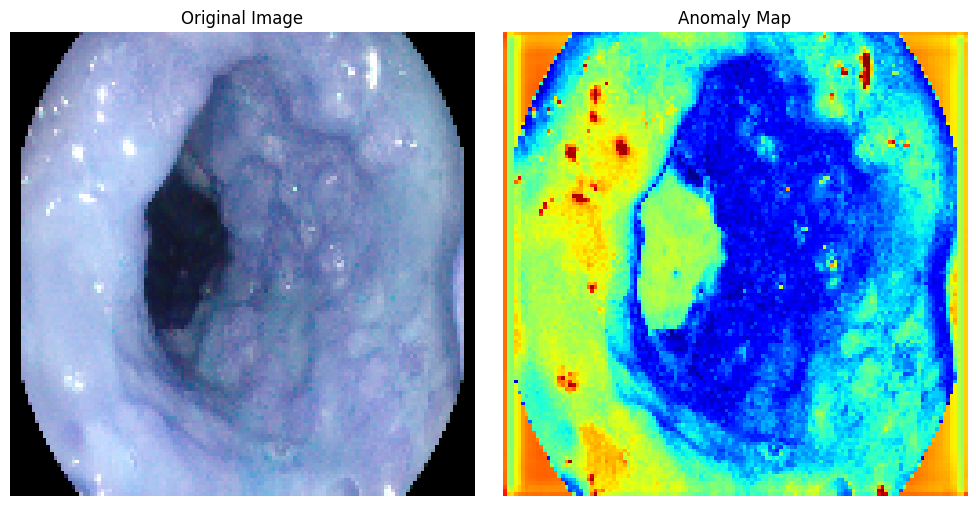

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to calculate anomaly map
def generate_anomaly_map(input_image, reconstructed_image):
    """
    Generate an anomaly map by calculating pixel-wise differences between the input
    and reconstructed images.

    Args:
        input_image (numpy array): Original input image (shape: H x W x C).
        reconstructed_image (numpy array): Reconstructed image from the autoencoder (shape: H x W x C).

    Returns:
        numpy array: Normalized anomaly map (shape: H x W).
    """
    # Calculate absolute pixel-wise difference
    difference = np.abs(input_image - reconstructed_image)

    # Sum differences across color channels to create a grayscale map
    anomaly_map = np.sum(difference, axis=-1)

    # Normalize anomaly map to [0, 1]
    anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())

    return anomaly_map

# Load and preprocess a test image
test_image_path = test_lesion_paths[6]  # Replace with a test lesion image path
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (128, 128)) / 255.0  # Normalize to [0, 1]

# Generate reconstructed image
reconstructed_image = attention_autoencoder.predict(test_image[np.newaxis, ...])[0]

# Generate anomaly map
anomaly_map = generate_anomaly_map(test_image, reconstructed_image)

# Visualize the anomaly map
def visualize_anomaly_map(original_image, anomaly_map):
    """
    Visualize the original image and anomaly map.

    Args:
        original_image (numpy array): Original input image.
        anomaly_map (numpy array): Anomaly map highlighting abnormal regions.
    """
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Anomaly Map
    plt.subplot(1, 2, 2)
    plt.imshow(anomaly_map, cmap='jet')
    plt.title("Anomaly Map")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the original image and anomaly map
visualize_anomaly_map(test_image, anomaly_map)


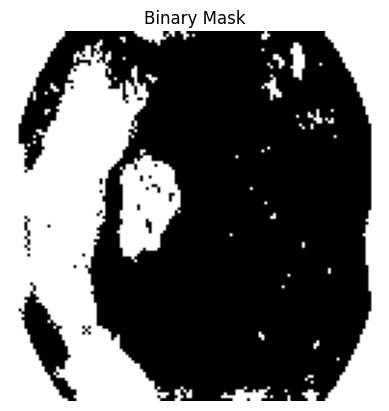

In [ ]:
threshold = 0.5  # Adjust this threshold based on experiments
binary_mask = (anomaly_map > threshold).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask")
plt.axis('off')
plt.show()


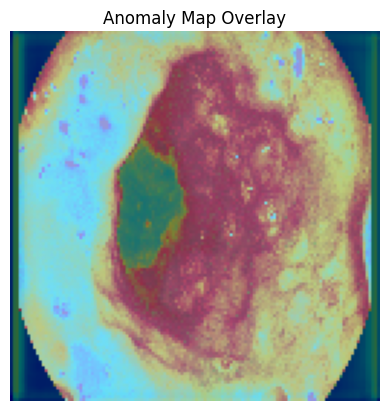

In [ ]:
overlay = cv2.addWeighted(
    (test_image * 255).astype(np.uint8), 0.6,
    cv2.applyColorMap((anomaly_map * 255).astype(np.uint8), cv2.COLORMAP_JET), 0.4,
    0
)
plt.imshow(overlay)
plt.title("Anomaly Map Overlay")
plt.axis('off')
plt.show()
